# __Segmentacion de clientes en un comercio online: Construir Modelos__

## Importar librerias

In [5]:
# librerias para el dataframe y la visualizacion
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# librerias para la clusterizacion
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree


## Cargar los datos

In [6]:
# datos con valores originales
rfm = pd.read_csv('./data/rfm.csv')
rfm.head()

,CustomerID,Monetary,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [7]:
# datos con valores escalados
rfm_df_scaled = pd.read_csv('./data/rfm_df_scaled.csv')
rfm_df_scaled.head()

,Monetary,Frequency,Recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


## Construir Modelo K-Means

Este modelo requiere inicializarlo con un numero de clustering definido. Vamos a iniciar con un numero de clustering de 4.

In [8]:
# instanciamos el modelo
kmeans = KMeans(n_clusters=4, max_iter=50, n_init=10, random_state=42)

# entrenamos el modelos con los datos escalados
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4, n_init=10, random_state=42)

Verifiquemos que el modelo entrenado presente las etiquetas de los 4 clusteres

In [9]:
kmeans.labels_

array([1, 0, 3, ..., 1, 3, 3], dtype=int32)

### _Encontrar el numero optimo de clusteres_

Vamos a implementar dos tecnicas muy comunes para encontrar la cantidad optima de clusteres que debemos utilizar en K-Means

__Metodo del codo__

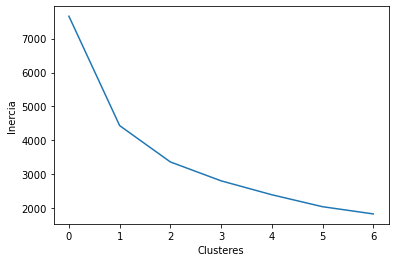

In [10]:
# lista para guardar la inercia de cada K
inercia = []

# definir el rango de K a probar
K = range(2, 9)

# iteramos sobre el modelo para cada valor de K
for n_cluster in K:
    kmeans = KMeans(n_clusters=n_cluster, max_iter=50, n_init=10, random_state=42)
    kmeans.fit(rfm_df_scaled)
    inercia.append(kmeans.inertia_)

plt.plot(inercia)
plt.xlabel('Clusteres')
plt.ylabel('Inercia')
plt.show()

> El grafico muestra la mayor perdida de inercia en el cluster 1. Sin embargo, el cluster 3 presenta un punto de inflexion en cuanto a la perdida de inercia.

__Indice de Silueta__

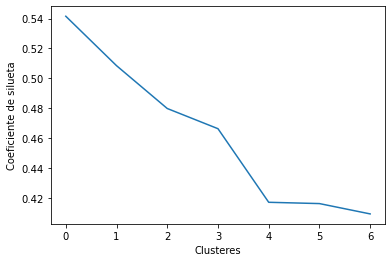

In [11]:
# lista para guardar los indice de silueta para cada cluster
index_silueta = []

# rango de K a probar
K = range(2, 9)

# itermaos el modelo para cada valor de K
for n_cluster in K:
    kmeans = KMeans(n_clusters=n_cluster, n_init=10, max_iter=50, random_state=42)
    y_pred = kmeans.fit_predict(rfm_df_scaled)
    index_silueta.append(silhouette_score(rfm_df_scaled, y_pred))

plt.plot(index_silueta)
plt.xlabel('Clusteres')
plt.ylabel('Coeficiente de silueta')
plt.show()

> La grafica muestra que hasta el cluster 3 el coeficiente de silueta no decae tanto.

### _Modelo optimo de clusterizacion_

Ambos metodos sugieren que con un numero de cluster igual a 3 podemos obtener un modelo de clusterizacion optimo. 

In [12]:
kmeans = KMeans(n_clusters=3, n_init=10, max_iter=50, random_state=42)
kmeans.fit(rfm_df_scaled)

# asignamos la etiqueta de clusterizacion a cada cliente del df
rfm['Cluster_K'] = kmeans.labels_
rfm.head() 

,CustomerID,Monetary,Frequency,Recency,Cluster_K
0,12346.0,0.00,2,325,1
1,12347.0,4310.00,182,1,0
2,12348.0,1797.24,31,74,2
3,12349.0,1757.55,73,18,2
4,12350.0,334.40,17,309,1


### _Visualizacion de los clusteres_

Creamos un scatterplot entre Recency y Frequency para visualizar los clusteres.

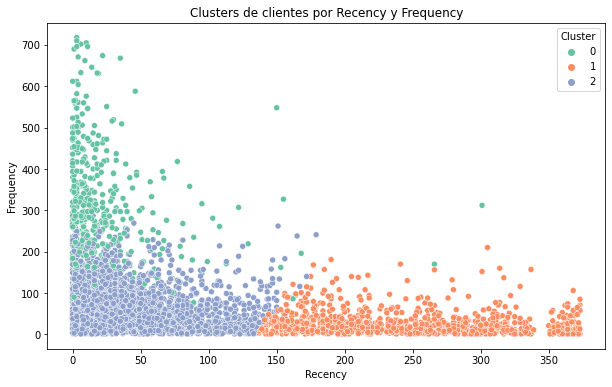

In [13]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='Cluster_K', palette='Set2')
plt.title('Clusters de clientes por Recency y Frequency')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend(title='Cluster')
plt.show()

> Se evidencian los tres clusteres bien definidos. 

> Los clientes del cluster 0, hacen muy a menudo sus pedidos por lo que la cantidad de dias que transcurre antes de pedir nuevamente es bajo.

> Los clientes del cluster 1, van a la tienda con una frecuencia baja media y por tanto, su recency esta entre 0 y 140 dias

> los clientes del cluster 2, presentan una frecuencia baja para hacer pedidos y por tanto tienden a durar mas dias antes de pedir nuevamente.

Creamos un scatterplot de Monetary vs Recency para visualizar los clusteres 

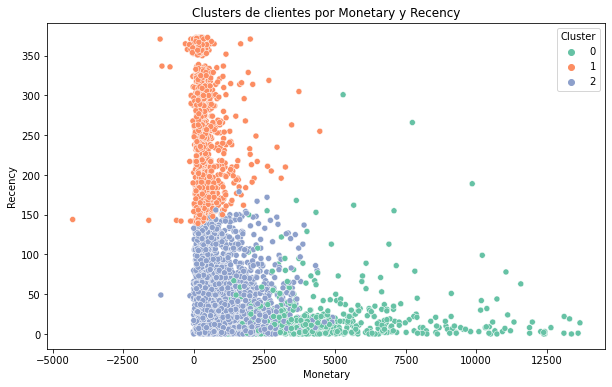

In [14]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm, x='Monetary', y='Recency', hue='Cluster_K', palette='Set2')
plt.title('Clusters de clientes por Monetary y Recency')
plt.xlabel('Monetary')
plt.ylabel('Recency')
plt.legend(title='Cluster')
plt.show()

> Se evidencian ingresos negativos de clientes lo cual debe analizarse.

> El cluster 0 corresponde a los clientes que hacen pedidos frecuentemente pero que gastan poco dinero.

> El cluster 1 corresponde a los clientes que hacen pedidos no tan frecuentemente con un gasto poco mas que los del cluster 0.

> El cluster 2 corresponde a los clientes que hacen pocos pedidos pero que gastan mucho mas al comprar.

## Construir modelo Hierarchical Clustering

Vamos a utilizar el modelo de aglomeracion jerarquica para clusterizar los clientes de acuerdo a RFM. Vamos a probar con diferentes metodos hasta encontrar aquel con el mejor resultado y de esta forma etiquetar a cada cliente.

### _Single Linkage_

la distancia entre dos grupos se define como la distancia más corta entre dos puntos en cada grupo.

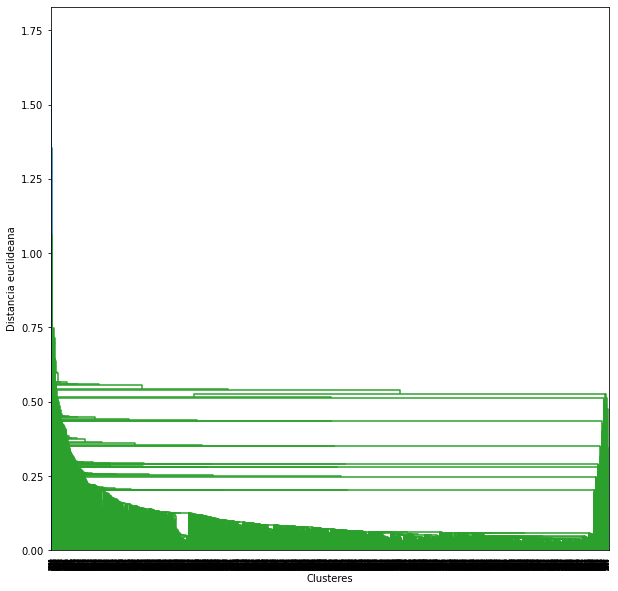

In [15]:
fig = plt.figure(figsize=(10,10))
dendogram_plot = dendrogram(linkage(rfm_df_scaled, method='single', metric='euclidean'))
plt.xlabel('Clusteres')
plt.ylabel('Distancia euclideana')
plt.show()

> No muestra claridad en cuanto a los clusteres que se pueden formar.

> Logra percibirse dos grupos: azul y verde, este ultimo siendo mas evidente.

### _Complete linkage_

La distancia entre dos grupos se define como la distancia más larga entre dos puntos en cada grupo.

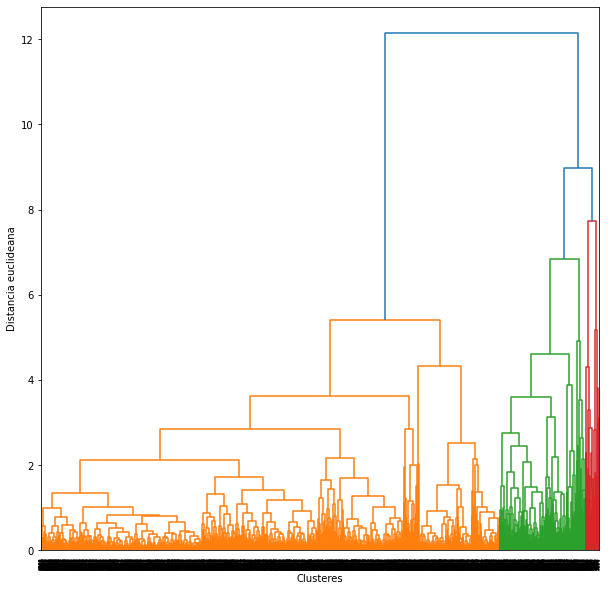

In [16]:
fig = plt.figure(figsize=(10,10))
dendogram_plot = dendrogram(linkage(rfm_df_scaled, method='complete', metric='euclidean'))
plt.xlabel('Clusteres')
plt.ylabel('Distancia euclideana')
plt.show()

> Se logra diferenciar 3 clusteres

> 2 de los clusteres son muy dominantes respecto al tercero.

> Arroja mejores resultados.

### _Average linkage_

La distancia entre dos grupos se define como la distancia promedio entre cada punto de un grupo y cada punto del otro grupo.

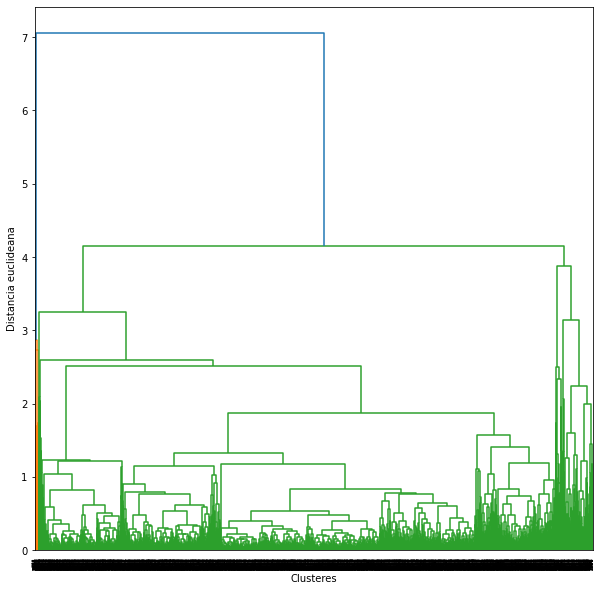

In [17]:
fig = plt.figure(figsize=(10,10))
dendogram_plot = dendrogram(linkage(rfm_df_scaled, method='average', metric='euclidean'))
plt.xlabel('Clusteres')
plt.ylabel('Distancia euclideana')
plt.show()

> Se evidencia la diferencia entre dos clusteres.

> No es tan claro pero se evidencia hasta 3 clusteres.

> Hay un cluster dominante frente al resto

### _Warm_

Realiza un monton de operaciones en el que cada datapoint se lleva a otro cluster, evalua su varianza y se queda con la varianza que de menor.

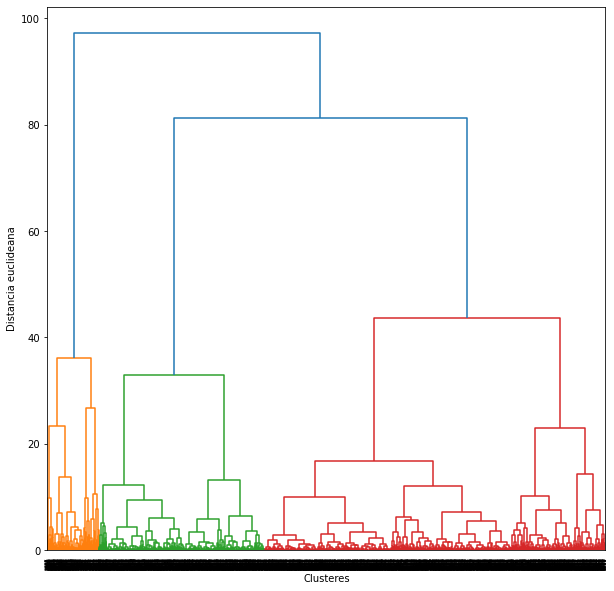

In [18]:
fig = plt.figure(figsize=(10,10))
dendogram_plot = dendrogram(linkage(rfm_df_scaled, method='ward', metric='euclidean'))
plt.xlabel('Clusteres')
plt.ylabel('Distancia euclideana')
plt.show()

> Se evidencia una mejor separacion entre 3 clusteres.

> Los 3 clusteres mantienen una buena distancia entre si, lo que indica una excelente clusterizacion.

> Es el metodo que arroja los mejores resultados

### Mejor Modelo

De los modelos creados, nos quedamos con Warm debido a su excelente diferenciacion de clusteres. Vamos a calcular el indice de silueta general para 2 y 3 clusteres y asi encontrar la mejor opcion.

In [19]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# para 2 clusteres
hc_2 = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')
y_hc_2 = hc_2.fit_predict(rfm_df_scaled)
print(silhouette_score(rfm_df_scaled, y_hc_2))

0.5788705653522203


In [20]:
# para 2 clusteres
hc_3 = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
y_hc_3 = hc_3.fit_predict(rfm_df_scaled)
print(silhouette_score(rfm_df_scaled, y_hc_3))

0.4643083907731691


> Evidentemente, con dos cluster obtenemos un indice de silueta mucho mayor debido a que dos de clusteres estan bien distanciados lo que los hace muy diferenciable respecto al restante.

> Nos quedamos con la clusterizacion para 3 clusteres ya que tiene una buena diferenciacion y el indice de silueta no es tan bajo.

In [21]:
rfm['cluster_hc'] = y_hc_3
rfm.head()

,CustomerID,Monetary,Frequency,Recency,Cluster_K,cluster_hc
0,12346.0,0.00,2,325,1,2
1,12347.0,4310.00,182,1,0,1
2,12348.0,1797.24,31,74,2,0
3,12349.0,1757.55,73,18,2,0
4,12350.0,334.40,17,309,1,2


### Visualizacion de los clusteres

Vamos a visualizar los clusteres formados a traves de boxplots para cada variable

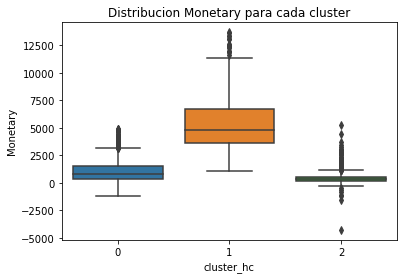

In [22]:
# cluster vs Monetary
sns.boxplot(x='cluster_hc', y='Monetary', data=rfm)
plt.title('Distribucion Monetary para cada cluster')
plt.show()

__Cluster 0:__

> La mediana esta alrededor de 1000$ con un IQR mas concentrado lo que genera cierta variabilidad.

> Se presentan outliers que llegan a mas de 4000$ pero tambien hay valores negativos que pueden deberse a devoluciones.

> Es considerado el grupo de clientes con gasto medio bajo.

__Cluster 1:__

> Presenta la mediana mas alta, con un valor de 5000$. Ademas muestra una mayor variablidad de gasto.

> Hay algunos datos con valores de mas de 12000 que son considerados outliers.

> Es considerado el grupo con los clientes mas valiosos debido a su alto gasto. Es el egmento prefecto para estrategias de fidelizacion.

__Cluster 2:__

> Presenta una mediana cercana a 0$ lo que representa clientes con pocos gastos.

> Hay datos aislados que son considerados outliers tanto positivos como negativos.

> Representan los clientes de bajo valor monetario. Pueden representar clientes de una sola compra o devoluciones.

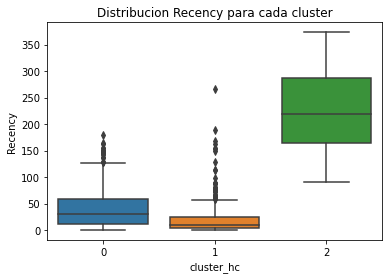

In [23]:
# cluster vs Recency
sns.boxplot(x='cluster_hc', y='Recency', data=rfm)
plt.title('Distribucion Recency para cada cluster')
plt.show()

Es importante tener en cuenta que Recency representa el tiempo que ha pasado desde la ultima compra. Valores bajos de recency son mejores ya que indican que el cliente compro recientemente. Valores altos indican clientes inactivos.

__Cluter 0:__

> La mediana ronda los 30 dias y presenta una distribucion entre 10 y 60 dias.

> Hay algunos outliers con mas de 100 dias.

> Son clientes activos, con compras reciente

__Cluster 1:__

> La mediana es de 10 dias y presenta una distribucion entre 0 y 30 dias.

> Es el grupo mas activo, con compra muy recientes y probablemente los mas comprometidos por lo que son ideales para campañas de fidelizacion.

__Cluster 2:__

> Presenta una mediana muy alta de aproximadamente 220 dias y una distribucion muy alta y amplia (de 90 a 360 dias).

> Son clientes inactivos o perdidos por lo que podrian necesitar de camapaña de recuperacion o reactivacion.


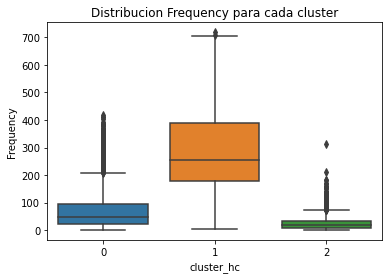

In [24]:
# cluster vs frequency
sns.boxplot(x='cluster_hc', y='Frequency', data=rfm)
plt.title('Distribucion Frequency para cada cluster')
plt.show()

La Frequency indica cuantas veces ha comprado un cliente. Valore altos de frequency implican clientes frecuentes.

__Cluster 0:__

> Mediana de aproximadamente 50 veces con muchos outliers por encima de 200.

> Son clientes moderadamente activos, que compran varias veces pero no tan a menudo. Representan un potencial de crecimiento.

__Cluster 1:__

> Mediana alta de aproximadamente 250, con outliers que superan las 700 veces.

> Son los clientes mas frecuentes, compran con regularidad y son de alto valor para el negocio.

__Cluster 2:__

> Mediana baja de 20 veces, con outliers por encima de 50 veces.

> Son clientes con muy poca frecuencia de compra. Son compradores esporadicos, ocasionales o inactivos.

### Conclusiones

Segun el analisis anterior, el cluster 0 corresponde a los clientes regulares: 

- Tienen un gasto medio bajo.
- Son activos, con compra recientes
- Compran varias veces pero no tan a menudo.

El cluster 1 corresponde a los clientes VIP:

- Presentan un alto gasto.
- Son lo mas activos, con la compra mas recientes.
- Hacen compras con mayor regularidad.

El cluster 2 correponde a los clientes inactivos o perdidos:

- Son los de bajo valor monetario.
- Son aquellos compran una vez, o generan devoluciones.
- Preentan poca frecuencia de compra.

## Construir modelo DBSCAN

Este modelo requiere determinar un rango de valores de epsilon (eps) y un rango de numero minimo de puntos dentro del radio eps. Procedemos a calcular cada rango.

### Rango optimo de epsilon

In [25]:
from sklearn.neighbors import NearestNeighbors

# calculo del vecino mas cercano
neighbors = NearestNeighbors(n_neighbors=2)
# ajuste del objeto a los datos
neighbors_fit = neighbors.fit(rfm_df_scaled)
# guardamos la distancia e indice de cada punto
distances, indices = neighbors_fit.kneighbors(rfm_df_scaled)

In [26]:
# ordenamos las distancias
distances = np.sort(distances, axis=0)
# tomar la distancia del vecino mas cercano de cada dato
distances = distances[:,1]

Creamos el grafico de k-distancias donde e ordenan la distancias al k-esimo vecino mas cercano. El codo generado indica un buen valor de eps.

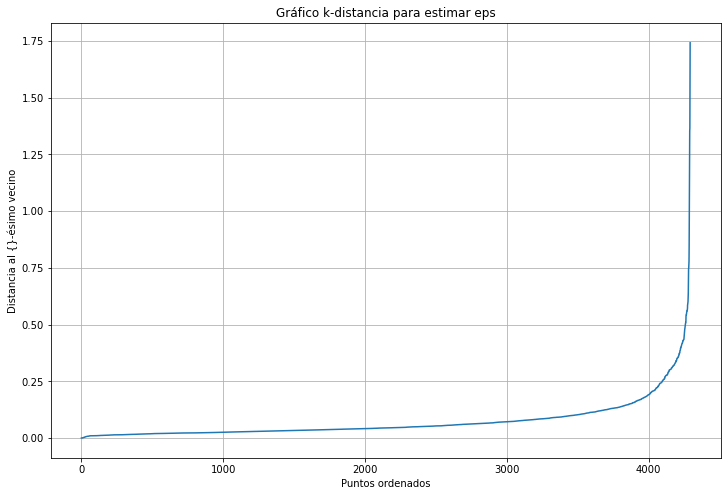

In [52]:
plt.figure(figsize=(12, 8))
plt.plot(distances)
plt.ylabel("Distancia al {}-ésimo vecino")
plt.xlabel("Puntos ordenados")
plt.title("Gráfico k-distancia para estimar eps")
plt.grid(True)
plt.show()

> El codo se encuentra entre 0.25 y 0.55 por lo que elegimos ese rango como rango de epsilon

In [67]:
# rango de epsilon
eps_values = np.arange(0.25, 0.60, 0.05)

### Rango optimo de min_samples

Para definir este rango, vamos a utilizar una regla empirica que indica que el valor minimo es la cantidad de feature mas 1 y el valor maximo es el doble del minimo. Sin embargo, es importante tener en cuenta que este rangoo se suele ajustar mejor por ensayo y error. Para este caso, lo definimos como sigue:

In [68]:
# rango de min_samples
min_samples = np.arange(4, 8)

### Obtener predicciones del modelo DBSCAN con los diferentes parametros

In [69]:
# libreria para combinar parametros
from itertools import product

# combinatoria de parametros
dbscan_params = list(product(eps_values, min_samples))

# lista para almacenar el numero de cluster
n_cluster = []

# lista para almacenar el indice de silueta
sil_score = []

# iteramos el modelo con la diferentes combinaciones de parametros
for p in dbscan_params:
    y_dbscan = DBSCAN(eps=p[0], min_samples=p[1]).fit_predict(rfm_df_scaled)
    
    try:
        sil_score.append(silhouette_score(rfm_df_scaled, y_dbscan))
    except:
        sil_score.append(0)

    n_cluster.append(len(np.unique(y_dbscan)))

Creamos un datarame con las predicciones del modelo junto a sus correspondientes parametros.

In [70]:
df_param_tunning = pd.DataFrame.from_records(dbscan_params, columns=['Eps', 'Min_samples'])
df_param_tunning['Sil_score'] = sil_score
df_param_tunning['N_clusters'] = n_cluster

df_param_tunning.head()

,Eps,Min_samples,Sil_score,N_clusters
0,0.25,4,0.010685,12
1,0.25,5,-0.114117,8
2,0.25,6,0.291444,6
3,0.25,7,-0.043372,8
4,0.30,4,0.041410,10


Creamos dos tablas dinamicas a partir del dataframe anterior para visualizar mejor el rendimiento de las distintas combinaciones de parametros en DBSCAN

In [71]:
pivot_1 = pd.pivot_table(df_param_tunning, values='Sil_score', columns='Eps', index='Min_samples')
pivot_2 = pd.pivot_table(df_param_tunning, values='N_clusters', columns='Eps', index='Min_samples')

pivot_1

Eps,0.25,0.30,0.35,0.40,0.45,0.50,0.55
Min_samples,,,,,,,
4,0.010685,0.041410,0.143179,0.052877,0.461600,0.593632,0.606081
5,-0.114117,0.236642,0.442860,0.199082,0.458037,0.597207,0.613268
6,0.291444,0.121581,0.544347,0.445233,0.131476,0.547516,0.551484
7,-0.043372,0.126959,0.494953,0.445894,0.460301,0.637395,0.624497


### Heatmap del indice de silueta y del numero de clusteres

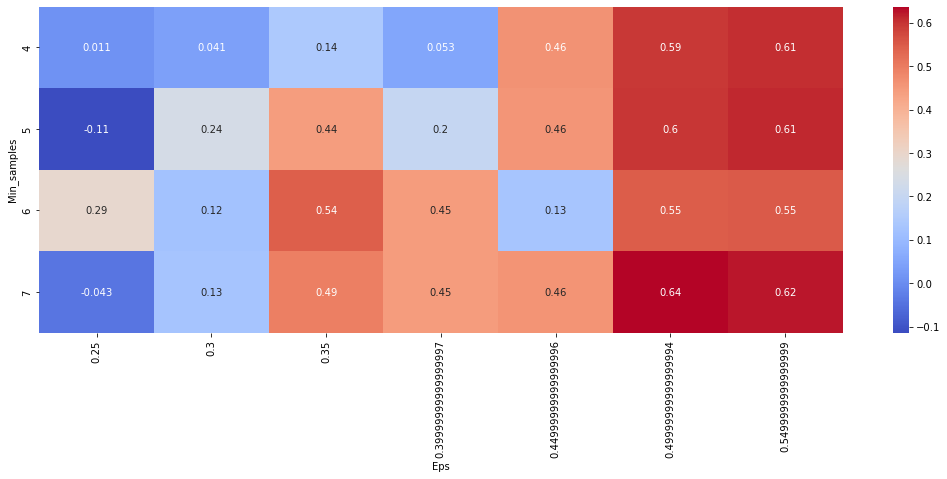

In [72]:
# heatmap del indice de silueta
fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={'size':10}, cmap='coolwarm', ax=ax)
plt.show()

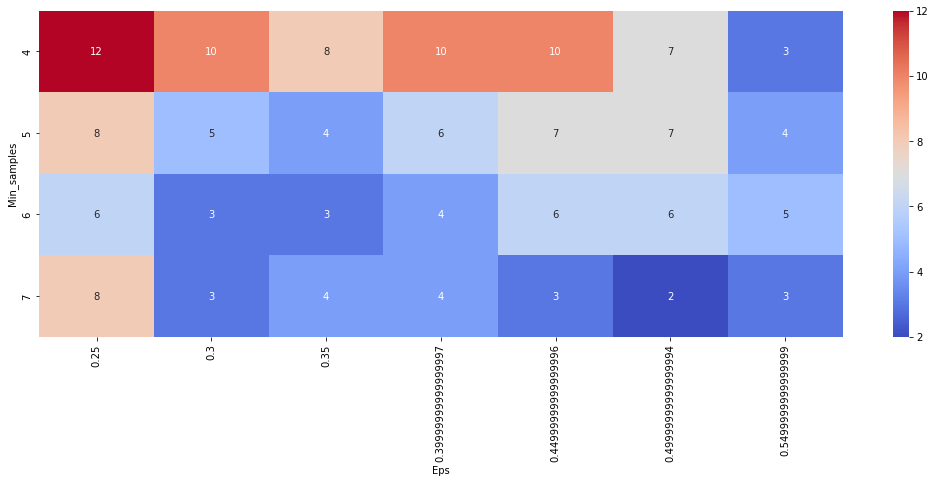

In [73]:
# heatmap del numero de cluster
fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_2, annot=True, annot_kws={'size':10}, cmap='coolwarm', ax=ax)
plt.show()

> Comparando ambos heatmaps, vemos que el indice de silueta mas alto (0.61) corresponde a un total de 3 clusteres que no es el mas bajo. Por tanto, esta eleccion se considera buena y corresponde a los parametros eps=0.549 y min_sample=4

> Vamos a entrenar DBSCAN con los parametros seleccionados para contrastar el resultado que se obtenga con el indice de silueta dado en el heatmap.

In [74]:
dbscan_train = DBSCAN(eps=0.549, min_samples=4)
y_dbscan = dbscan_train.fit_predict(rfm_df_scaled)
print(silhouette_score(rfm_df_scaled, y_dbscan))

0.6060806889707244


> Como vemos, el indice de silueta que arroja el modelo concuerda con el valor presentado en el heatmap.

> Guardamos las predicciones de DBSCAN en el dataframe con los datos originales 'rfm'

In [76]:
rfm['Cluster_dbscan'] = y_dbscan
rfm.head()

,CustomerID,Monetary,Frequency,Recency,Cluster_K,cluster_hc,Cluster_dbscan
0,12346.0,0.00,2,325,1,2,0
1,12347.0,4310.00,182,1,0,1,0
2,12348.0,1797.24,31,74,2,0,0
3,12349.0,1757.55,73,18,2,0,0
4,12350.0,334.40,17,309,1,2,0
